In [2]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'pyhessian'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [24]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
train_X = torch.tensor(train_X, dtype=torch.float32)/255
test_X = torch.tensor(test_X, dtype=torch.float32)/255
train_y = torch.tensor(train_y, dtype=torch.int64)
test_y = torch.tensor(test_y, dtype=torch.int64)

In [27]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=64, shuffle=True)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
losses = []
test_losses = []
train_losses = []
for epoch in range(10):
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            output = model(train_X)
            loss_train = criterion(output, train_y)
            output = model(test_X)
            loss_test = criterion(output, test_y)
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            output_test = model(test_X)
            test_losses.append(loss_test.item())
            train_losses.append(loss_train.item())
    #print(loss.item())

Epoch 0, step 0, train_loss 2.313136339187622, test_loss 2.2927510738372803
Epoch 0, step 1000, train_loss 0.16292282938957214, test_loss 0.25185373425483704
Epoch 1, step 0, train_loss 0.09870645403862, test_loss 0.2104179710149765
Epoch 1, step 1000, train_loss 0.05806225538253784, test_loss 0.16792713105678558
Epoch 2, step 0, train_loss 0.07268346101045609, test_loss 0.15083296597003937
Epoch 2, step 1000, train_loss 0.07811782509088516, test_loss 0.14243188500404358
Epoch 3, step 0, train_loss 0.11187191307544708, test_loss 0.14590562880039215
Epoch 3, step 1000, train_loss 0.31613418459892273, test_loss 0.13026003539562225
Epoch 4, step 0, train_loss 0.15821173787117004, test_loss 0.1336156725883484
Epoch 4, step 1000, train_loss 0.008282882161438465, test_loss 0.1267145574092865
Epoch 5, step 0, train_loss 0.013209063559770584, test_loss 0.13167160749435425
Epoch 5, step 1000, train_loss 0.03416845202445984, test_loss 0.12906789779663086
Epoch 6, step 0, train_loss 0.00825704075

In [35]:
# Calculate test accuracy
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9616


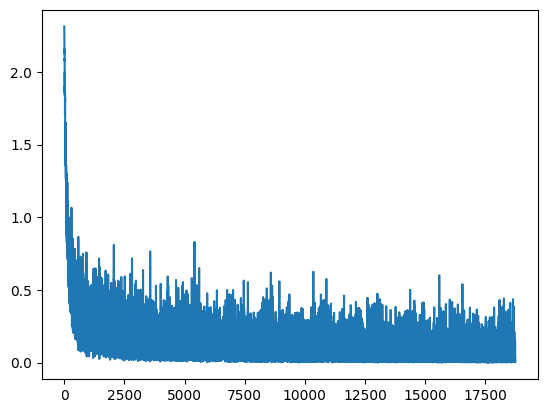

In [36]:
%matplotlib inline
plt.plot(losses)
plt.show()

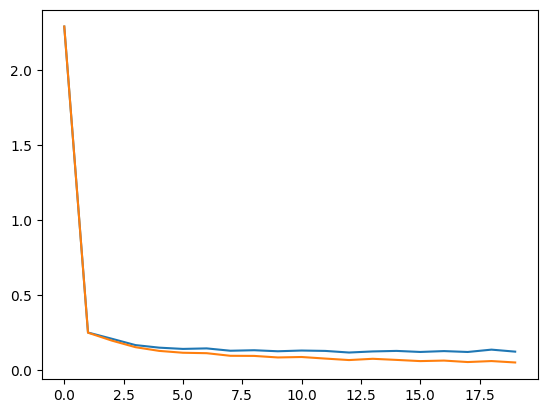

In [37]:
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [38]:
# finding test loss
output = model(train_X)
loss = criterion(output, train_y)
print(loss.item())

0.051979273557662964


In [39]:
hessian_comp = hessian(model, criterion, data=(train_X, train_y), cuda=False)


In [40]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 29.0457


In [ ]:
# top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=20)
# print("The top two eigenvalues of this model are: ", top_eigenvalues)

The top two eigenvalues of this model are:  [1.608893871307373, 1.2666716575622559, 1.101566195487976, 0.9621520638465881, 0.7985818982124329, 0.7562527656555176, 0.5832130908966064, 0.43961480259895325, 0.49059900641441345, 0.4274073541164398, 0.34394925832748413, 0.3396146595478058, 0.28575974702835083, 0.3115382790565491, 0.27783316373825073, 0.2528150677680969, 0.2573324739933014, 0.25158432126045227, 0.23695391416549683, 0.22765429317951202]


c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\code\density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


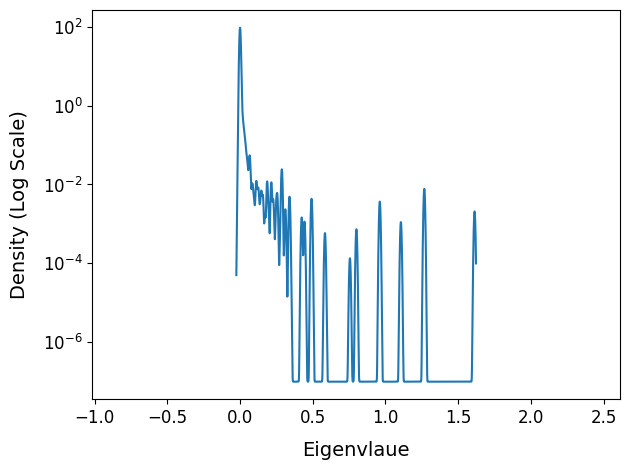

In [42]:
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight)